In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats import zscore
from scipy import stats
from scipy.stats import ttest_rel, ttest_ind, wilcoxon
rng = np.random.default_rng()
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
from patsy.contrasts import Treatment
import warnings
warnings.filterwarnings('ignore')

In [250]:
df = pd.read_csv("transformed_data.csv")

In [251]:
# Summary Statistics
# List of variables for summary stats
summary_vars = [
    'Age', 'Gender', 'High_wealth', 'Own_asset', 'Intere_inves',
    'Trade_frequently', 'numcorrect_financialliteracyall', 'Risk_taking',
    'Patient', 'Share_willing', 'Donate_charity', 'Donation',
    'Sustainability_Value', 'correct_Environ_Literacy', 'High_CurrentSustainShare',
    'Invest_in_SRI', 'correct_comprehension', 'Stat_know',
    'Number_think', 'Number_inter'
]

# Summary stats by treatment_num
summary_table = df[summary_vars + ['treatment_num']].groupby('treatment_num').agg(
    ['count', 'mean', 'std', 'min', 'max']
)

# Flatten column MultiIndex
summary_table.columns = ['_'.join(col).strip() for col in summary_table.columns.values]

In [252]:
# Map treatment labels to treatments
treatment_labels = {
    1: "Baseline",
    2: "Green",
    3: "Brown",
    4: "Green Low"
}

# Map treatment_num to label
df['treatment_label'] = df['treatment_num'].map(treatment_labels)

In [253]:
#T-tests Main Effects Allocations to Assets

def run_ttest(df, var, treat_col, group1, group2):
    group1_data = df[df[treat_col] == group1][var].dropna()
    group2_data = df[df[treat_col] == group2][var].dropna()
    
    tstat, pval = ttest_ind(group2_data, group1_data, equal_var=False)
    diff = group2_data.mean() - group1_data.mean()
    
    return {
        'Variable': var,
        'Group 1': treatment_labels[group1],
        'Group 2': treatment_labels[group2],
        'Mean Group 1': round(group1_data.mean(), 2),
        'Mean Group 2': round(group2_data.mean(), 2),
        'Difference': round(diff, 2),
        'T-Statistic': round(tstat, 2),
        'P-Value': round(pval, 4)
    }


In [254]:
tests = [
    ('HighCorr_investmentAsset_lowret', 1, 2),  # Baseline vs Green (Positive Corr)
    ('LowCorr_investmentAsset_lowret', 1, 2),   # Baseline vs Green (Negative Corr)
    ('HighCorr_investmentAsset_lowret', 1, 3),  # Baseline vs Brown (Positive Corr)
    ('LowCorr_investmentAsset_lowret', 1, 3),   # Baseline vs Brown (Negative Corr)
]

results = [run_ttest(df, var, 'treatment_num', g1, g2) for var, g1, g2 in tests]
results_df = pd.DataFrame(results)

In [255]:
results_df

,Variable,Group 1,Group 2,Mean Group 1,Mean Group 2,Difference,T-Statistic,P-Value
0,HighCorr_investmentAsset_lowret,Baseline,Green,0.0,0.0,-0.0,-1.28,0.2019
1,LowCorr_investmentAsset_lowret,Baseline,Green,0.0,0.0,-0.0,-4.00,0.0001
2,HighCorr_investmentAsset_lowret,Baseline,Brown,0.0,0.0,-0.0,-3.58,0.0004
3,LowCorr_investmentAsset_lowret,Baseline,Brown,0.0,0.0,-0.0,-4.67,0.0000


In [256]:
# Extend the list of variables to test
more_tests = [
    ('correlation_neglect', 1, 2),
    ('correlation_neglect', 1, 3),
    ('consider_corr', 1, 2),
    ('consider_corr', 1, 3)
]

# Combine with previous
all_tests = tests + more_tests

# Run all
all_results = [run_ttest(df, var, 'treatment_num', g1, g2) for var, g1, g2 in all_tests]
ttest_results_df = pd.DataFrame(all_results)


In [257]:
ttest_results_df

,Variable,Group 1,Group 2,Mean Group 1,Mean Group 2,Difference,T-Statistic,P-Value
0,HighCorr_investmentAsset_lowret,Baseline,Green,0.0,0.0,-0.0,-1.28,0.2019
1,LowCorr_investmentAsset_lowret,Baseline,Green,0.0,0.0,-0.0,-4.00,0.0001
2,HighCorr_investmentAsset_lowret,Baseline,Brown,0.0,0.0,-0.0,-3.58,0.0004
3,LowCorr_investmentAsset_lowret,Baseline,Brown,0.0,0.0,-0.0,-4.67,0.0000
4,correlation_neglect,Baseline,Green,0.0,0.0,0.0,1.85,0.0659
5,correlation_neglect,Baseline,Brown,0.0,0.0,0.0,0.53,0.5997
6,consider_corr,Baseline,Green,-0.0,-0.0,-0.0,-1.85,0.0659
7,consider_corr,Baseline,Brown,-0.0,-0.0,-0.0,-0.53,0.5997


In [258]:
#T-Tests — Deviation from Optimal Allocation
highcorr_optimal = 23.90
lowcorr_optimal = 45.60


def ttest_optimal(df, var, optimal_value, treatment):
    data = df[df['treatment_num'] == treatment][var].dropna()
    tstat, pval = ttest_1samp(data, popmean=optimal_value)
    diff = data.mean() - optimal_value

    return {
        'Variable': var,
        'Treatment': treatment_labels.get(treatment, treatment),
        'Mean': round(data.mean(), 2),
        'Optimal': optimal_value,
        'Difference': round(diff, 2),
        'T-Statistic': round(tstat, 2),
        'P-Value': round(pval, 4)
    }

optimal_tests = []

# Test deviation from optimal for HighCorr
for treatment in [1, 2, 3]:
    optimal_tests.append(ttest_optimal(df, 'HighCorr_investmentAsset_lowret', highcorr_optimal, treatment))

# Test deviation from optimal for LowCorr
for treatment in [1, 2, 3]:
    optimal_tests.append(ttest_optimal(df, 'LowCorr_investmentAsset_lowret', lowcorr_optimal, treatment))

optimal_tests_df = pd.DataFrame(optimal_tests)

In [259]:
optimal_tests_df

,Variable,Treatment,Mean,Optimal,Difference,T-Statistic,P-Value
0,HighCorr_investmentAsset_lowret,Baseline,0.0,23.9,-23.9,-10835464.02,0.0
1,HighCorr_investmentAsset_lowret,Green,0.0,23.9,-23.9,-9861343.72,0.0
2,HighCorr_investmentAsset_lowret,Brown,0.0,23.9,-23.9,-10072935.48,0.0
3,LowCorr_investmentAsset_lowret,Baseline,0.0,45.6,-45.6,-21074797.94,0.0
4,LowCorr_investmentAsset_lowret,Green,0.0,45.6,-45.6,-25275534.21,0.0
5,LowCorr_investmentAsset_lowret,Brown,0.0,45.6,-45.6,-23342745.47,0.0


In [260]:
#Main Effects on Share_lowreturn (T-Tests Low Correlation Scenario)

# Filter the data for relevant treatments
df_t12 = df[df['treatment_num'].isin([1, 2])]
df_t13 = df[df['treatment_num'].isin([1, 3])]

# T-test: Treatment 1 vs 2
t12_group1 = df_t12[df_t12['treatment_num'] == 1]['LowCorr_investmentAsset_lowret'].dropna()
t12_group2 = df_t12[df_t12['treatment_num'] == 2]['LowCorr_investmentAsset_lowret'].dropna()
t_stat_t12, p_val_t12 = ttest_ind(t12_group1, t12_group2, equal_var=True)

# T-test: Treatment 1 vs 3
t13_group1 = df_t13[df_t13['treatment_num'] == 1]['LowCorr_investmentAsset_lowret'].dropna()
t13_group2 = df_t13[df_t13['treatment_num'] == 3]['LowCorr_investmentAsset_lowret'].dropna()
t_stat_t13, p_val_t13 = ttest_ind(t13_group1, t13_group2, equal_var=True)

print(f"Treatment 1 vs 2: t = {t_stat_t12:.2f}, p = {p_val_t12:.3f}")
print(f"Treatment 1 vs 3: t = {t_stat_t13:.2f}, p = {p_val_t13:.3f}")


Treatment 1 vs 2: t = 4.00, p = 0.000
Treatment 1 vs 3: t = 4.66, p = 0.000


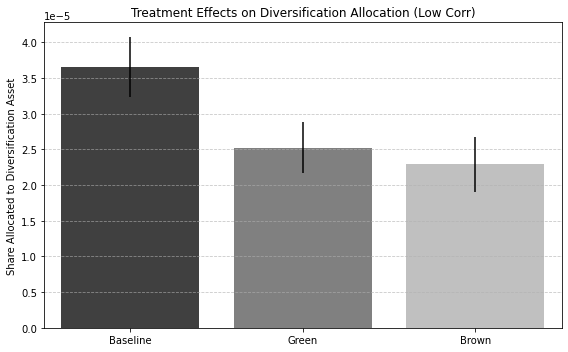

In [261]:
#Plot Main Treatment Effects (Low Correlation Scenario)

# Prepare summary stats
grouped = df[df['treatment_num'].isin([1, 2, 3])].groupby('treatment_num')['LowCorr_investmentAsset_lowret']
means = grouped.mean()
stds = grouped.std()
counts = grouped.count()
cis = 1.96 * (stds / np.sqrt(counts))  

# Treatment labels
labels = ['Baseline', 'Green', 'Brown']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=means.values, yerr=cis.values, capsize=0.2, palette='gray')

plt.ylabel("Share Allocated to Diversification Asset")
plt.title("Treatment Effects on Diversification Allocation (Low Corr)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("treatment_effects_lowcorr.png", dpi=300)
plt.show()


In [262]:
#Main Effects on Share_lowreturn (T-Tests High Correlation Scenario)
# T-test: HighCorr_investmentAsset_lowret (Treatment 1 vs 2 and 1 vs 3)
df_t12 = df[df['treatment_num'].isin([1, 2])]
df_t13 = df[df['treatment_num'].isin([1, 3])]

# T1 vs T2
t12_group1 = df_t12[df_t12['treatment_num'] == 1]['HighCorr_investmentAsset_lowret'].dropna()
t12_group2 = df_t12[df_t12['treatment_num'] == 2]['HighCorr_investmentAsset_lowret'].dropna()
t_stat_t12_pos, p_val_t12_pos = ttest_ind(t12_group1, t12_group2, equal_var=True)

# T1 vs T3
t13_group1 = df_t13[df_t13['treatment_num'] == 1]['HighCorr_investmentAsset_lowret'].dropna()
t13_group2 = df_t13[df_t13['treatment_num'] == 3]['HighCorr_investmentAsset_lowret'].dropna()
t_stat_t13_pos, p_val_t13_pos = ttest_ind(t13_group1, t13_group2, equal_var=True)

print(f"Treatment 1 vs 2 (High Corr): t = {t_stat_t12_pos:.2f}, p = {p_val_t12_pos:.3f}")
print(f"Treatment 1 vs 3 (High Corr): t = {t_stat_t13_pos:.2f}, p = {p_val_t13_pos:.3f}")


Treatment 1 vs 2 (High Corr): t = 1.28, p = 0.202
Treatment 1 vs 3 (High Corr): t = 3.58, p = 0.000


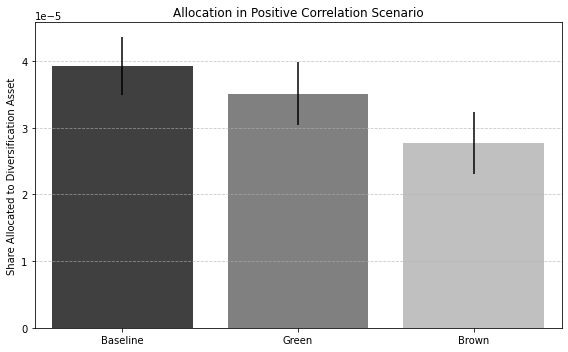

In [263]:
# #Plot Main Treatment Effects (High Correlation Scenario)
# Prepare summary stats
grouped_high = df[df['treatment_num'].isin([1, 2, 3])].groupby('treatment_num')['HighCorr_investmentAsset_lowret']
means_high = grouped_high.mean()
stds_high = grouped_high.std()
counts_high = grouped_high.count()
cis_high = 1.96 * (stds_high / np.sqrt(counts_high))

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=means_high.values, yerr=cis_high.values, capsize=5, palette='gray')

plt.ylabel("Share Allocated to Diversification Asset")
plt.title("Allocation in Positive Correlation Scenario")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [264]:
# Treatment Effects Correlation Neglect
# T1 vs T2
t12_group1 = df[df['treatment_num'] == 1]['correlation_neglect'].dropna()
t12_group2 = df[df['treatment_num'] == 2]['correlation_neglect'].dropna()
t_stat_cn_12, p_val_cn_12 = ttest_ind(t12_group1, t12_group2, equal_var=True)

# T1 vs T3
t13_group1 = df[df['treatment_num'] == 1]['correlation_neglect'].dropna()
t13_group2 = df[df['treatment_num'] == 3]['correlation_neglect'].dropna()
t_stat_cn_13, p_val_cn_13 = ttest_ind(t13_group1, t13_group2, equal_var=True)

print(f"Treatment 1 vs 2 (Corr Neglect): t = {t_stat_cn_12:.2f}, p = {p_val_cn_12:.3f}")
print(f"Treatment 1 vs 3 (Corr Neglect): t = {t_stat_cn_13:.2f}, p = {p_val_cn_13:.3f}")


Treatment 1 vs 2 (Corr Neglect): t = -1.85, p = 0.066
Treatment 1 vs 3 (Corr Neglect): t = -0.52, p = 0.600


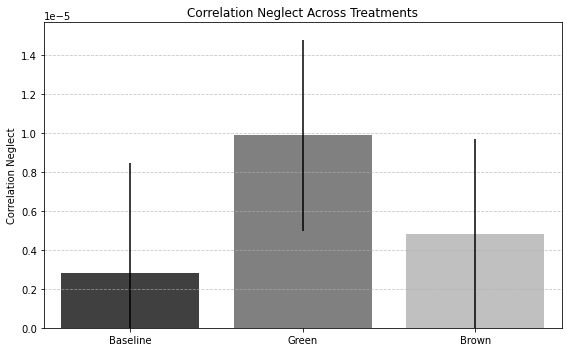

In [265]:
# Summary stats
grouped_cn = df[df['treatment_num'].isin([1, 2, 3])].groupby('treatment_num')['correlation_neglect']
means_cn = grouped_cn.mean()
stds_cn = grouped_cn.std()
counts_cn = grouped_cn.count()
cis_cn = 1.96 * (stds_cn / np.sqrt(counts_cn))

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=means_cn.values, yerr=cis_cn.values, capsize=0.2, palette='gray')

plt.ylabel("Correlation Neglect")
plt.title("Correlation Neglect Across Treatments")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, None)
plt.tight_layout()
plt.show()


In [271]:
#Regression Models Main Effects Allocations
# Ensure consistent treatment coding 
df['treatment_num'] = pd.Categorical(df['treatment_num'], categories=[1, 2, 3], ordered=True)

# Expand Dataframe with per round observation
df_expanded = pd.concat([df.copy(), df.copy()], ignore_index=False)

# Create 'dup' variable: alternates 0, 1 per individual
df_expanded = df_expanded.sort_values(['id'], ascending =True)
df_expanded['dup'] = [0, 1] * (len(df_expanded) // 2)


# First and Second round variables
df_expanded['First_Round'] = np.where(df_expanded['dup'] == 0, 1, 0)
df_expanded['Second_Round'] = np.where(df_expanded['dup'] == 1, 1, 0)

# Create High_Corr variable
df_expanded['High_Corr'] = np.select(
    [
        (df_expanded['First_Round'] == 1) & (df_expanded['P1_low_first'] == 0),
        (df_expanded['First_Round'] == 1) & (df_expanded['P1_low_first'] == 1),
        (df_expanded['First_Round'] == 0) & (df_expanded['P1_low_first'] == 1),
        (df_expanded['First_Round'] == 0) & (df_expanded['P1_low_first'] == 0)
    ],
    [1, 0, 1, 0]
)


# Create Low_Corr as the inverse
df_expanded['Low_Corr'] = 1 - df_expanded['High_Corr']


# Interaction of High Corr with First_Round
df_expanded['FirstRound_HighCorr'] = df_expanded['High_Corr'] * df_expanded['First_Round']


# Assign Share_lowreturn based on round and asset type
df_expanded['Share_lowreturn'] = np.where(
    df_expanded['First_Round'] == 1,
    df_expanded['P1_investmentAsset_lowreturn'],
    df_expanded['P2_investmentAsset_lowreturn']
)

# Transform to percentage
df_expanded['Share_lowreturn'] = (df_expanded['Share_lowreturn'] / 10000) * 100

# Define helper function to run clustered regression with treatment 1 as the reference group

def run_regression(df, dependent_var, independent_vars, treatment_col, id_col):
    # Construct the regression formula with interaction terms
    formula = f"{dependent_var} ~ {' + '.join(independent_vars)} + C({treatment_col}, Treatment(reference=1))+ C({treatment_col}, Treatment(reference=1)) * High_Corr"

    # Fit the OLS model with clustered standard errors
    model = smf.ols(formula, data=df).fit(cov_type='cluster', cov_kwds={'groups': df[id_col]})
    return model



# Define independent variables for the regression
independent_vars = [
    'Age', 'Gender', 'High_wealth', 'Patient', 'Risk_taking', 'Social_Preferences',
    'Donation', 'Sustainability_Value', 'numcorrect_financialliteracyall',
    'correct_Environ_Literacy', 'Stat_know', 'Number_think', 'Number_inter',
    'Own_asset', 'Intere_inves', 'Trade_frequently', 'High_CurrentSustainShare', 'P1_high_return', 'First_Round', 'FirstRound_HighCorr'
]

,dup,First_Round,P1_low_first,High_Corr,id
0,0,1,0,1,1
0,1,0,0,0,1
1,0,1,1,0,2
1,1,0,1,1,2
2,0,1,1,0,3
...,...,...,...,...,...
357,1,0,1,1,500
358,0,1,1,0,501
358,1,0,1,1,501
359,0,1,1,0,502


In [272]:
# Subset for Green vs. Baseline
df_green = df_expanded[df_expanded['treatment_num'].isin([1, 2])].copy()
df_green['treatment_num'] = pd.Categorical(df_green['treatment_num'], categories=[1, 2], ordered=True)

# Subset for Brown vs. Baseline
df_brown = df_expanded[df_expanded['treatment_num'].isin([1, 3])].copy()
df_brown['treatment_num'] = pd.Categorical(df_brown['treatment_num'], categories=[1, 3], ordered=True)


# Run regressions
model_green = run_regression(df_green, 'Share_lowreturn', independent_vars, 'treatment_num', 'id')
model_brown = run_regression(df_brown, 'Share_lowreturn', independent_vars, 'treatment_num', 'id')

# Rename labels for clarity 
df_expanded = df_expanded.rename(columns={
    "First_Round": "First Round",
    "Share_lowreturn": "Share Diversification Asset",
    "High_Corr": "Positive Correlation",
    "Low_Corr": "Negative Correlation"
})

# Combine into LaTeX regression table
main_effects_table = summary_col(
    [model_green, model_brown],
    stars=True,
    model_names=["Green vs Baseline", "Brown vs Baseline"],
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.2f}",
        'N': lambda x: f"{int(x.nobs)}"
    },
    float_format="%.2f"
)

# Print and save LaTeX
latex_main = main_effects_table.as_latex()
print(latex_main)

with open("main_effects_regression_results.tex", "w") as f:
    f.write(latex_main)


\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                                                          & Green vs Baseline & Brown vs Baseline  \\
\hline
Age                                                       & 0.00              & 0.07               \\
                                                          & (0.11)            & (0.11)             \\
C(treatment\_num, Treatment(reference=1))[T.2]            & -11.15***         &                    \\
                                                          & (2.96)            &                    \\
C(treatment\_num, Treatment(reference=1))[T.2]:High\_Corr & 7.16*             &                    \\
                                                          & (3.88)            &                    \\
C(treatment\_num, Treatment(reference=1))[T.3]            &                   & -12.64***          \\
                                                          &                   & (2.91)             \

In [199]:
main_effects_table

,Green vs Baseline,Brown vs Baseline
Age,-0.13,0.04
,(0.12),(0.13)
"C(treatment_num, Treatment(reference=1))[T.2]",-17.87***,
,(5.02),
"C(treatment_num, Treatment(reference=1))[T.2]:First_Round",10.17*,
,(5.88),
"C(treatment_num, Treatment(reference=1))[T.2]:High_Corr",5.99,
,(5.81),
"C(treatment_num, Treatment(reference=1))[T.3]",,-14.94***
,,(5.14)


In [132]:
# Regression Beliefs on Returns
# Define common control variables
controls = [
    "Age", "Gender", "High_wealth", "Patient", "Risk_taking", "Social_Preferences", 
    "Donation", "Sustainability_Value", "numcorrect_financialliteracyall", 
    "correct_Environ_Literacy", "Stat_know", "Number_think", "Number_inter", 
    "Own_asset", "Intere_inves", "Trade_frequently", "High_CurrentSustainShare", 
    "correct_comprehension", "correct_dependence", "P1_high_return"
]

# Construct control string
control_str = " + ".join(controls)

# Create Lower_Bound, Upper_Bound, Expect_value based on First_Round
df["Expect_value"] = df["P1_Expect_value"].where(df["First_Round"] == 1, df["P2_Expect_value"])
df["Lower_Bound"] = df["P1_belief_lower"].where(df["First_Round"] == 1, df["P2_belief_lower"])
df["Upper_Bound"] = df["P1_belief_upper"].where(df["First_Round"] == 1, df["P2_belief_upper"])


# Treatment interaction
treatment_interaction = "C(treatment_num)*High_Corr + First_Round*High_Corr"

# Final formula function
def make_formula(y_var):
    return f"{y_var} ~ {treatment_interaction} + {control_str}"


In [133]:
# Filter for Green sample
df_green = df[df['treatment_num'].isin([1, 2])].copy()
df_green['treatment_num'] = pd.Categorical(df_green['treatment_num'], categories=[1, 2])


model_lower_green = smf.ols(make_formula("Lower_Bound"), data=df_green).fit(cov_type='cluster', cov_kwds={'groups': df_green["id"]})
model_upper_green = smf.ols(make_formula("Upper_Bound"), data=df_green).fit(cov_type='cluster', cov_kwds={'groups': df_green["id"]})
model_expect_green = smf.ols(make_formula("Expect_value"), data=df_green).fit(cov_type='cluster', cov_kwds={'groups': df_green["id"]})


In [134]:
# Filter for Brown sample
df_brown = df[df['treatment_num'].isin([1, 3])].copy()
df_brown['treatment_num'] = pd.Categorical(df_brown['treatment_num'], categories=[1, 3])


model_lower_brown = smf.ols(make_formula("Lower_Bound"), data=df_brown).fit(cov_type='cluster', cov_kwds={'groups': df_brown["id"]})
model_upper_brown = smf.ols(make_formula("Upper_Bound"), data=df_brown).fit(cov_type='cluster', cov_kwds={'groups': df_brown["id"]})
model_expect_brown = smf.ols(make_formula("Expect_value"), data=df_brown).fit(cov_type='cluster', cov_kwds={'groups': df_brown["id"]})


In [135]:
belief_models = {
    "Lower_Bound_Green": model_lower_green,
    "Upper_Bound_Green": model_upper_green,
    "Expected_Value_Green": model_expect_green,
    "Lower_Bound_Brown": model_lower_brown,
    "Upper_Bound_Brown": model_upper_brown,
    "Expected_Value_Brown": model_expect_brown,
} 



In [136]:
# Format the regression models for output
belief_table = summary_col(
    list(belief_models.values()),
    stars=True,
    model_names=list(belief_models.keys()),
    info_dict={
        'R-squared': lambda x: f"{x.rsquared:.2f}",
        'N': lambda x: f"{int(x.nobs)}"
    },
    float_format="%.2f"
)


belief_table


,Lower_Bound_Green,Upper_Bound_Green,Expected_Value_Green,Lower_Bound_Brown,Upper_Bound_Brown,Expected_Value_Brown
Age,0.00,-0.00,0.00,-0.00,-0.00,-0.00
,(0.00),(0.00),(0.00),(0.00),(0.00),(0.00)
C(treatment_num)[T.2],0.00,-0.01,-0.01,,,
,(0.03),(0.03),(0.02),,,
C(treatment_num)[T.2]:High_Corr,-0.01,0.01,0.02,,,
,(0.03),(0.04),(0.03),,,
C(treatment_num)[T.3],,,,-0.02,0.01,0.00
,,,,(0.03),(0.03),(0.02)
C(treatment_num)[T.3]:High_Corr,,,,0.03,-0.01,0.02
,,,,(0.04),(0.04),(0.03)


In [ ]:
# Print the LaTeX output
latex_belief = belief_table.as_latex()
print(latex_belief)

# Save to file
with open("beliefs_regression_results.tex", "w") as f:
    f.write(latex_belief)